In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
from scipy import fftpack
%matplotlib inline

In [2]:
# Select a region (Amazon, Argentina)
# region_name = 'Amazon'
region_name = 'Argentina'

# Min number of MCS to plot
min_ntracks = 10

# Define region bounds
box_arg = [-68,-50,-40,-20]
box_amz = [-75,-40,-20,5]
# Lookup region based on input
bounds_dict = {'Argentina':box_arg, 'Amazon':box_amz}
bounds = bounds_dict[region_name]
print(f'{region_name}: {bounds}')

Argentina: [-68, -50, -40, -20]


In [3]:
# test = ''
# rootdir = '/global/cscratch1/sd/feng045/SAAG/'
# obsfile = f'{rootdir}GPM/stats{test}/robust_mcs_tracks_20180601_20190630.nc'
# wrffile = f'{rootdir}June2018_May2019_nsp/stats{test}/robust_mcs_tracks_20180601_20190630.nc'

years = [2010, 2015, 2018]

# rootdir = '/global/cscratch1/sd/feng045/SAAG/mcs_tracking/3year_test_simulation/'
rootdir = '/global/project/projectdirs/m1657/zfeng/SAAG/mcs_tracking/3year_test_simulation/'
gpmfiles = []
wrffiles = []
for yy in years:
    gpmfiles = gpmfiles + sorted(glob.glob(f'{rootdir}GPM/stats/mcs_tracks_final_{yy}*.nc'))
    wrffiles = wrffiles + sorted(glob.glob(f'{rootdir}WRF/stats/mcs_tracks_final_{yy}*.nc'))
nyears_obs = len(gpmfiles)
nyears_wrf = len(wrffiles)
print(f'Number of years (OBS): {nyears_obs}')
print(f'Number of years (WRF): {nyears_wrf}')
figdir = f'/global/project/projectdirs/m1657/zfeng/SAAG/figures/'
os.makedirs(figdir, exist_ok=True)

Number of years (OBS): 3
Number of years (WRF): 3


In [4]:
# Read OBS data
# dsobs = xr.open_dataset(obsfile)
dsobs = xr.open_mfdataset(gpmfiles, concat_dim='tracks', combine='nested')
# Renumber the tracks so they are unique
ntracks_obs = dsobs.dims['tracks']
dsobs['tracks'] = np.arange(0, ntracks_obs)
# dsobs

In [5]:
# Read wrf data
# dswrf = xr.open_dataset(wrffile)
dswrf = xr.open_mfdataset(wrffiles, concat_dim='tracks', combine='nested')
# Renumber the tracks so they are unique
ntracks_wrf = dswrf.dims['tracks']
dswrf['tracks'] = np.arange(0, ntracks_wrf)
# dswrf

In [6]:
def utc2lt(UTC, lon):
    """
    A simple function to convert UTC time to local solar time for a given longitude.
    Arguments:
       UTC (array-like): time in UTC.
       lon (array-like): longitude in degrees.
    Returns:
       localtime (array-like): local solar time.
    Created: Zhe.Feng@pnnl.gov, 19-April-2021
    """
    
    # Hour per degree longitude 
    hourperdeg = 24./360.
    # Convert to local time
    localtime = UTC + lon * hourperdeg
    
    # Adjust time
    if np.count_nonzero(localtime >= 24) > 0:
        localtime[np.where(localtime >= 24)] -= 24
    
    if np.count_nonzero(localtime < 0) > 0:
        localtime[np.where(localtime < 0)] += 24

    return localtime

def harmonic_phase_amplitude(var, nharm, hr1, binsize=1.0):
    """
    Calculates the harmonic phase and amplitude for the requested number
    of harmonics. The phase indicates the location of the peak closest to
    T=0 for each harmonic along the T-axis--it can be on either side of 0.
    Arguments:
       var   = array to be analyzed, XT ordering assumed.
       nharm = number of harmonics to calculate
       hr1   = hour of the first time in the time series--used to adj. phase to be 0 at 0 hrs
       binsize = size of the hour bin for calculating phase. default=1.0
    Returns:
       amp[nharm] = amplitude of each harmonic
       phs[nharm] = phase of each harmonic, with 0 phase set to hour 0
       pvar[nharm] = percent variance explained
    Created: William.Gustafson@pnnl.gov, 17-Jan-2014
    Last modified: William.Gustafson@pnnl.gov, 22-Jan-2014
    Modified by: Zhe.Feng@pnnl.gov, 10-Jan-2019
    """
    nt = var.shape[-1]
#     w = float(nt) / (2.*np.arccos(-1.))
    w = float(nt) * binsize / (2.*np.arccos(-1.))
    ft = fftpack.fft(var, axis=-1)

    # 0th index returned by fft is the trend, so harmonics start at 1
    ampall = np.abs(ft)[1:] * 2./float(nt)  # need all amplitudes to get total variance
    amp = ampall[0:nharm]
    phs = np.angle(ft)[1:nharm+1]
#     phs = np.angle(ft)[1:nharm+1] * binsize

    totvar = 0.5*np.sum(ampall*ampall)  # total variance
    zeros = np.where(totvar < 1e-12, True, False)  # Need to mask out zero variance values for getting percent values
    totvar_nozeros = np.where(zeros, 1., totvar)
    pvar = np.empty_like(amp)

    for n in range(nharm):
        np1 = n + 1  # adjust by one to get the harmonic number vs. its index
#         phs_offset_max = float(nt)/float(np1)  # max possible phase offset for this harmonic
        phs_offset_max = float(nt) * binsize / float(np1)  # max possible phase offset for this harmonic

        # Have to switch rotation direction of the phase angle to get
        # where first peak occurs. We want it to indicate the angle where
        # the peak occurs. We also do the shift here for the offset due
        # to the first hour not being at 0 (what was sent into this routine).
        phs[n] = phs_offset_max - phs[n] * w / float(np1) + hr1

        # Now, we adjust for a phase that might be a multiple of the given harmonic.
        phs[n] = np.where(phs[n]>phs_offset_max, phs[n]-phs_offset_max, phs[n])
        phs[n] = np.where(phs[n]<0, phs[n] + float(nt)*binsize/float(np1), phs[n])

        # Get percent variance explained by each harmonic.
        pvar[n] = np.where(zeros, 0., 100.*(0.5*amp[n]*amp[n])/totvar_nozeros)
    
    return amp, phs, pvar

In [7]:
# Get track initial time valuees
base_time_obs = dsobs.base_time.load()
starttime_obs = base_time_obs.isel(times=0)
syear_obs = starttime_obs.dt.year.load()
landfrac_obs = dsobs.pf_landfrac.load()
lat0_obs = dsobs.meanlat.isel(times=0)
lon0_obs = dsobs.meanlon.isel(times=0)
# landfrac0_obs = landfrac_obs.isel(times=0)
landfrac0_obs = landfrac_obs.isel(times=slice(0,3)).mean(dim='times')
print(f'Number of MCS (OBS): {len(lat0_obs)}')

Number of MCS (OBS): 13919


In [8]:
# Get track initial time valuees
base_time_wrf = dswrf.base_time.load()
starttime_wrf = base_time_wrf.isel(times=0)
syear_wrf = starttime_wrf.dt.year.load()
landfrac_wrf = dswrf.pf_landfrac.load()
lat0_wrf = dswrf.meanlat.isel(times=0)
# lon0_wrf = dswrf.meanlon.isel(times=0)
lon0_wrf = ((dswrf.meanlon.isel(times=0) - 180) % 360) - 180
# landfrac0_wrf = landfrac_wrf.isel(times=0)
landfrac0_wrf = landfrac_wrf.isel(times=slice(0,3)).mean(dim='times')
print(f'Number of MCS (wrf): {len(lat0_wrf)}')

Number of MCS (wrf): 10417


(array([ 637., 1163., 1116., 1553., 1267., 1222., 1052., 1029.,  746.,
         632.]),
 array([-81.91666 , -77.12999 , -72.34332 , -67.556656, -62.76999 ,
        -57.983322, -53.196655, -48.40999 , -43.62332 , -38.836655,
        -34.049988], dtype=float32),
 <BarContainer object of 10 artists>)

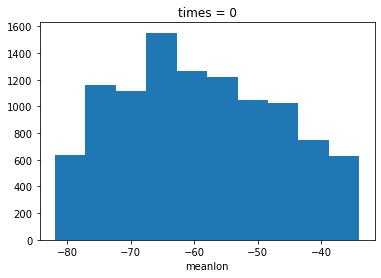

In [9]:
lon0_wrf.plot.hist()

(array([1471.,  117.,   98.,   58.,   91.,   84.,   69.,  116.,  142.,
        8144.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

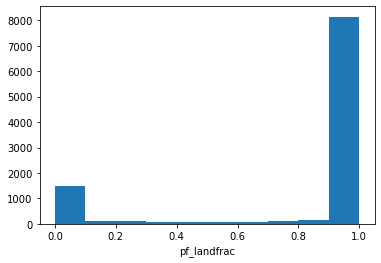

In [10]:
landfrac0_wrf.plot.hist()

In [11]:
# Convert UTC time to local time
hourUTC_obs = base_time_obs.dt.hour + (base_time_obs.dt.minute / 60)
hourLT_obs = utc2lt(hourUTC_obs.values, dsobs.meanlon.values)
hourLT_obs = xr.DataArray(hourLT_obs, coords={'tracks':dsobs.tracks, 'times':dsobs.times}, dims=('tracks','times'))

In [12]:
# Convert UTC time to local time
hourUTC_wrf = base_time_wrf.dt.hour + (base_time_wrf.dt.minute / 60)
hourLT_wrf = utc2lt(hourUTC_wrf.values, dswrf.meanlon.values)
hourLT_wrf = xr.DataArray(hourLT_wrf, coords={'tracks':dswrf.tracks, 'times':dswrf.times}, dims=('tracks','times'))

In [13]:
landfrac_thres = 0.8
oceanfrac_thres = 0.2

trackid_obs = np.where((lon0_obs >= bounds[0]) & (lon0_obs <= bounds[1]) & (lat0_obs >= bounds[2]) & (lat0_obs <= bounds[3]))[0]
trackid_obs_l = np.where((lon0_obs >= bounds[0]) & (lon0_obs <= bounds[1]) & (lat0_obs >= bounds[2]) & (lat0_obs <= bounds[3]) & 
                     (landfrac0_obs > landfrac_thres))[0]
trackid_obs_o = np.where((lon0_obs >= bounds[0]) & (lon0_obs <= bounds[1]) & (lat0_obs >= bounds[2]) & (lat0_obs <= bounds[3]) & 
                     (landfrac0_obs < oceanfrac_thres))[0]

ntracks_obs = len(trackid_obs)
ntracks_obs_l = len(trackid_obs_l)
ntracks_obs_o = len(trackid_obs_o)
print(f'Number of MCS (OBS): {ntracks_obs} (All), {ntracks_obs_l} (Land), {ntracks_obs_o} (Ocean)')

Number of MCS (OBS): 1274 (All), 1106 (Land), 63 (Ocean)


In [14]:
trackid_wrf = np.where((lon0_wrf >= bounds[0]) & (lon0_wrf <= bounds[1]) & (lat0_wrf >= bounds[2]) & (lat0_wrf <= bounds[3]))[0]
trackid_wrf_l = np.where((lon0_wrf >= bounds[0]) & (lon0_wrf <= bounds[1]) & (lat0_wrf >= bounds[2]) & (lat0_wrf <= bounds[3]) & 
                     (landfrac0_wrf > landfrac_thres))[0]
trackid_wrf_o = np.where((lon0_wrf >= bounds[0]) & (lon0_wrf <= bounds[1]) & (lat0_wrf >= bounds[2]) & (lat0_wrf <= bounds[3]) & 
                     (landfrac0_wrf < oceanfrac_thres))[0]

ntracks_wrf = len(trackid_wrf)
ntracks_wrf_l = len(trackid_wrf_l)
ntracks_wrf_o = len(trackid_wrf_o)
print(f'Number of MCS (wrf): {ntracks_wrf} (All), {ntracks_wrf_l} (Land), {ntracks_wrf_o} (Ocean)')

Number of MCS (wrf): 1036 (All), 929 (Land), 54 (Ocean)


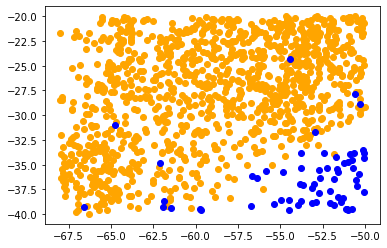

In [15]:
plt.plot(lon0_obs.sel(tracks=trackid_obs_l), lat0_obs.sel(tracks=trackid_obs_l), 'o', color='orange')
plt.plot(lon0_obs.sel(tracks=trackid_obs_o), lat0_obs.sel(tracks=trackid_obs_o), 'o', color='blue')

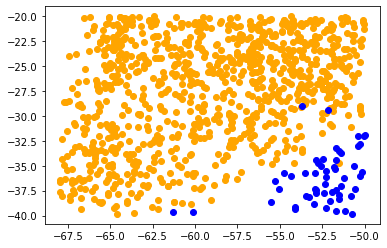

In [16]:
plt.plot(lon0_wrf.sel(tracks=trackid_wrf_l), lat0_wrf.sel(tracks=trackid_wrf_l), 'o', color='orange')
plt.plot(lon0_wrf.sel(tracks=trackid_wrf_o), lat0_wrf.sel(tracks=trackid_wrf_o), 'o', color='blue')

In [17]:
binhour = np.arange(0, 24.1, 2)
binhour_v = binhour[:-1] + np.diff(binhour)/2
pdf_inithour_obs_l, bins = np.histogram(hourLT_obs.sel(tracks=trackid_obs_l).isel(times=0), bins=binhour, range=(0,24), density=True)
pdf_inithour_obs_o, bins = np.histogram(hourLT_obs.sel(tracks=trackid_obs_o).isel(times=0), bins=binhour, range=(0,24), density=True)

pdf_inithour_wrf_l, bins = np.histogram(hourLT_wrf.sel(tracks=trackid_wrf_l).isel(times=0), bins=binhour, range=(0,24), density=True)
pdf_inithour_wrf_o, bins = np.histogram(hourLT_wrf.sel(tracks=trackid_wrf_o).isel(times=0), bins=binhour, range=(0,24), density=True)

In [18]:
pdf_mcshour_obs_l, bins = np.histogram(hourLT_obs.where(dsobs.pf_mcsstatus == 1).sel(tracks=trackid_obs_l), bins=binhour, range=(0,24), density=True)
pdf_mcshour_obs_o, bins = np.histogram(hourLT_obs.where(dsobs.pf_mcsstatus == 1).sel(tracks=trackid_obs_o), bins=binhour, range=(0,24), density=True)

pdf_mcshour_wrf_l, bins = np.histogram(hourLT_wrf.where(dswrf.pf_mcsstatus == 1).sel(tracks=trackid_wrf_l), bins=binhour, range=(0,24), density=True)
pdf_mcshour_wrf_o, bins = np.histogram(hourLT_wrf.where(dswrf.pf_mcsstatus == 1).sel(tracks=trackid_wrf_o), bins=binhour, range=(0,24), density=True)

In [19]:
nharm = 8
binsize = 2
amp_init_obs_l, phs_init_obs_l, pvar_init_obs_l = harmonic_phase_amplitude(pdf_inithour_obs_l, nharm, 0., binsize=binsize)
amp_init_obs_o, phs_init_obs_o, pvar_init_obs_o = harmonic_phase_amplitude(pdf_inithour_obs_o, nharm, 0., binsize=binsize)

amp_init_wrf_l, phs_init_wrf_l, pvar_init_wrf_l = harmonic_phase_amplitude(pdf_inithour_wrf_l, nharm, 0., binsize=binsize)
amp_init_wrf_o, phs_init_wrf_o, pvar_init_wrf_o = harmonic_phase_amplitude(pdf_inithour_wrf_o, nharm, 0., binsize=binsize)

amp_mat_obs_l, phs_mat_obs_l, pvar_mat_obs_l = harmonic_phase_amplitude(pdf_mcshour_obs_l, nharm, 0., binsize=binsize)
amp_mat_obs_o, phs_mat_obs_o, pvar_mat_obs_o = harmonic_phase_amplitude(pdf_mcshour_obs_o, nharm, 0., binsize=binsize)

amp_mat_wrf_l, phs_mat_wrf_l, pvar_mat_wrf_l = harmonic_phase_amplitude(pdf_mcshour_wrf_l, nharm, 0., binsize=binsize)
amp_mat_wrf_o, phs_mat_wrf_o, pvar_mat_wrf_o = harmonic_phase_amplitude(pdf_mcshour_wrf_o, nharm, 0., binsize=binsize)

In [20]:
def plot_2diurnal(dataobs, datawrf, binhour_v, titles, xlabels, ylabels, xticks, legendobs, legendwrf, legendloc, 
                  map_extent, lonbox, latbox, inset_param, figname):

    mpl.rcParams['font.size'] = 14
    mpl.rcParams['font.family'] = 'Helvetica'

    fig = plt.figure(figsize=[8,8], dpi=100)
    gs = gridspec.GridSpec(2,1, height_ratios=[1,1], width_ratios=[1])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.2, hspace=0.25)

    for row in range(0,2):
        ax = plt.subplot(gs[row])
        ax.plot(binhour_v, dataobs[row], color='k', lw=2, label=legendobs[row])
        ax.plot(binhour_v, datawrf[row], color='tomato', lw=2, label=legendwrf[row])
        ax.grid(which='major', ls='--')
        ax.set_xlabel(xlabels[row])
        ax.set_ylabel(ylabels[row])
        ax.set_xticks(xticks)
        ax.set_title(titles[row], loc='left')
        ax.legend(fontsize=12, loc=legendloc[row])

        # Plot inset map
        resolution = '50m'
        land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
        ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
        borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
        # borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
        proj = ccrs.PlateCarree(central_longitude=180)
        sub_ax = inset_axes(ax, width=inset_param[row]['width'], height=inset_param[row]['height'], loc=inset_param[row]['loc'],
                            axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param[row]['borderpad'], 
                            axes_kwargs=dict(map_projection=proj))
        sub_ax.set_extent(map_extent, crs=ccrs.PlateCarree())
        # Add land, coastlines, borders to inset
        sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k', lw=2)
        sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
        sub_ax.add_feature(borders, edgecolor='k', facecolor='none', lw=0.7, zorder=3)
#         sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
        # Plot a box region in the inset
        box = sgeom.box(minx=lonbox[0], maxx=lonbox[1], miny=latbox[0], maxy=latbox[1])
        sub_ax.add_geometries([box], ccrs.PlateCarree(), facecolor='none', edgecolor='g', lw=2)
        sub_ax.add_geometries([box], ccrs.PlateCarree(), facecolor='g', edgecolor='none', alpha=0.3)

    fig.savefig(figname, dpi=300, facecolor='w', bbox_inches='tight')
    
    return fig

In [21]:
years = f'{syear_obs.min().item()}-{syear_obs.max().item()}'
years

'2010-2019'

In [22]:
f'{figdir}mcs_initiation_mature_time_diurnal_cycle_{region_name}_land_{years}.png'

'/global/project/projectdirs/m1657/zfeng/SAAG/figures/mcs_initiation_mature_time_diurnal_cycle_Argentina_land_2010-2019.png'

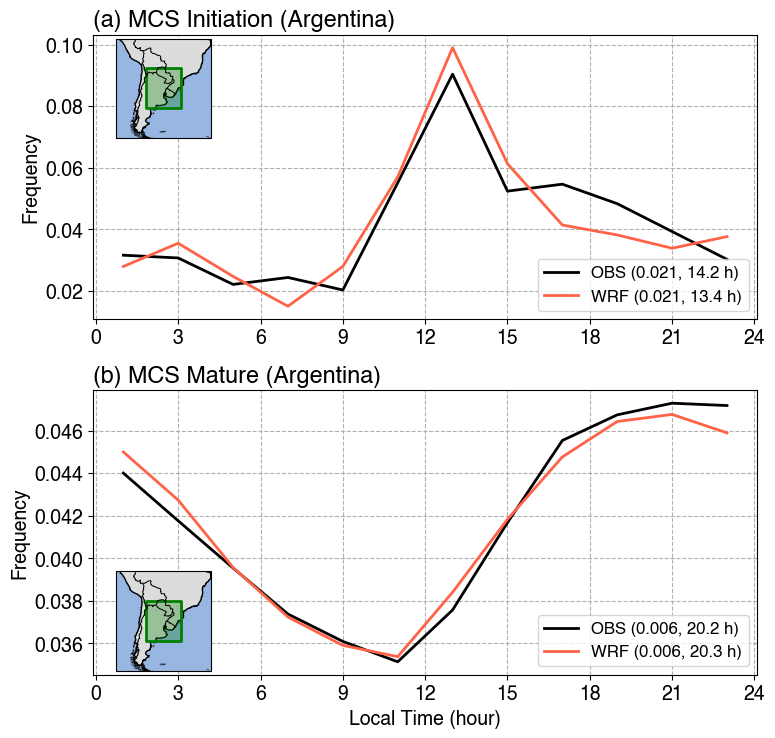

In [23]:
if (ntracks_obs_l > min_ntracks) & (ntracks_wrf_l > min_ntracks):
    dataobs = [pdf_inithour_obs_l, pdf_mcshour_obs_l]
    datawrf = [pdf_inithour_wrf_l, pdf_mcshour_wrf_l]
    titles = [f'(a) MCS Initiation ({region_name})', f'(b) MCS Mature ({region_name})']
    xlabels = ['','Local Time (hour)']
    ylabels = ['Frequency', 'Frequency']
    xticks = np.arange(0,25,3)
    legendobs = [f'OBS ({amp_init_obs_l[0]:.03f}, {phs_init_obs_l[0]:2.1f} h)', 
                 f'OBS ({amp_mat_obs_l[0]:.03f}, {phs_mat_obs_l[0]:2.1f} h)']
    legendwrf = [f'WRF ({amp_init_wrf_l[0]:.03f}, {phs_init_wrf_l[0]:2.1f} h)', 
                  f'WRF ({amp_mat_wrf_l[0]:.03f}, {phs_mat_wrf_l[0]:2.1f} h)']
    legendloc = ['lower right', 'lower right']
    map_extent = [bounds[0]-15,bounds[1]+15,bounds[2]-15,bounds[3]+15]
    if max(bounds) > 180:
        lonbox = ((np.array([bounds[0], bounds[1]]) - 180) % 360) - 180
    else:
        lonbox = np.array([bounds[0], bounds[1]])
    latbox = [bounds[2], bounds[3]]
    inset_param = [{'width':'20%', 'height':'35%', 'loc':'upper left', 'borderpad':0.2}, 
                   {'width':'20%', 'height':'35%', 'loc':'lower left', 'borderpad':0.2}]
    figname = f'{figdir}mcs_initiation_mature_time_diurnal_cycle_{region_name}_land_{years}.png'
    fig = plot_2diurnal(dataobs, datawrf, binhour_v, titles, xlabels, ylabels, xticks, legendobs, legendwrf, legendloc, 
                      map_extent, lonbox, latbox, inset_param, figname)

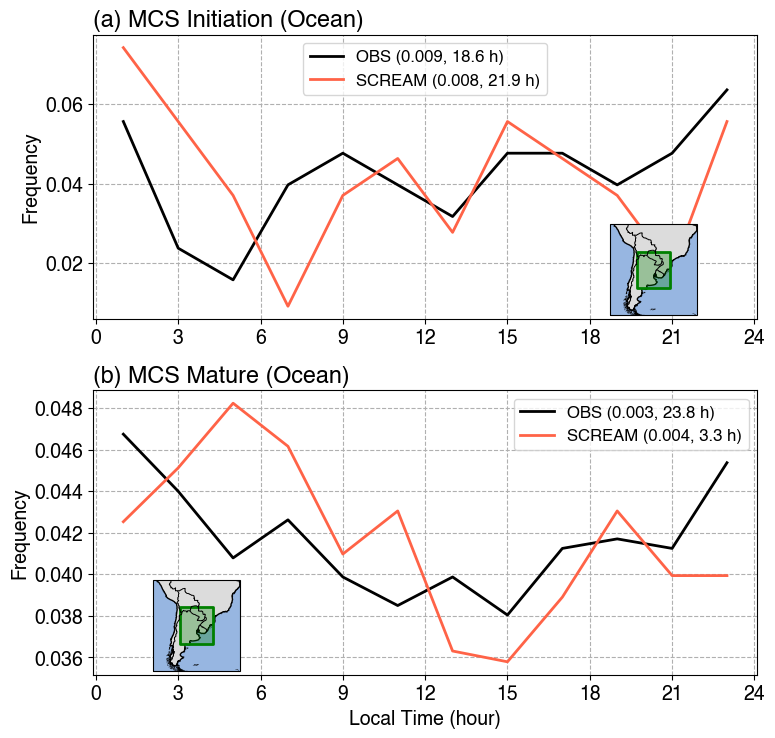

In [24]:
if (ntracks_obs_o > min_ntracks) & (ntracks_wrf_o > min_ntracks):
    dataobs = [pdf_inithour_obs_o, pdf_mcshour_obs_o]
    datawrf = [pdf_inithour_wrf_o, pdf_mcshour_wrf_o]
    titles = ['(a) MCS Initiation (Ocean)', '(b) MCS Mature (Ocean)']
    xlabels = ['','Local Time (hour)']
    ylabels = ['Frequency', 'Frequency']
    xticks = np.arange(0,25,3)
    legendobs = [f'OBS ({amp_init_obs_o[0]:.03f}, {phs_init_obs_o[0]:2.1f} h)', 
                 f'OBS ({amp_mat_obs_o[0]:.03f}, {phs_mat_obs_o[0]:2.1f} h)']
    legendwrf = [f'SCREAM ({amp_init_wrf_o[0]:.03f}, {phs_init_wrf_o[0]:2.1f} h)', 
                  f'SCREAM ({amp_mat_wrf_o[0]:.03f}, {phs_mat_wrf_o[0]:2.1f} h)']
#     legendloc = ['lower left', 'lower left']
    legendloc = ['best', 'best']
    map_extent = [bounds[0]-15,bounds[1]+15,bounds[2]-15,bounds[3]+15]
    if max(bounds) > 180:
        lonbox = ((np.array([bounds[0], bounds[1]]) - 180) % 360) - 180
    else:
        lonbox = np.array([bounds[0], bounds[1]])
    latbox = [bounds[2], bounds[3]]
    inset_param = [{'width':'30%', 'height':'32%', 'loc':'lower right', 'borderpad':0.2}, 
                   {'width':'30%', 'height':'32%', 'loc':'lower left', 'borderpad':0.2}]
    figname = f'{figdir}mcs_initiation_mature_time_diurnal_cycle_{region_name}_ocean_{years}.png'
    fig = plot_2diurnal(dataobs, datawrf, binhour_v, titles, xlabels, ylabels, xticks, legendobs, legendwrf, legendloc, 
                      map_extent, lonbox, latbox, inset_param, figname)

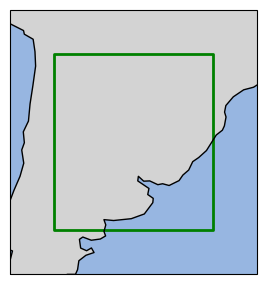

In [25]:
# map_extend = [0.1, 359.9, -60.1, 60.1]
map_extent = [bounds[0]-5,bounds[1]+5,bounds[2]-5,bounds[3]+5]
lonv = np.arange(-180,180.1,30)
latv = np.arange(-60,60.1,15)
proj = ccrs.PlateCarree(central_longitude=0)
resolution = '110m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)

fig = plt.figure(figsize=[10,3.5], dpi=100)
ax = plt.subplot(111, projection=proj)
ax.set_extent(map_extent, crs=ccrs.PlateCarree())
ax.add_feature(land, facecolor='none', edgecolor='k', zorder=2)
# ax.set_aspect('auto', adjustable=None)
ax.add_feature(land, facecolor='lightgray')
ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])

box = sgeom.box(minx=lonbox[0], maxx=lonbox[1], miny=latbox[0], maxy=latbox[1])
ax.add_geometries([box], ccrs.PlateCarree(), facecolor='none', edgecolor='g', lw=2)
    
# gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
# gl.xlocator = mpl.ticker.FixedLocator(lonv)
# gl.ylocator = mpl.ticker.FixedLocator(latv)
# # gl.top_labels = False
# # gl.right_labels = False
# # gl.xformatter = LONGITUDE_FORMATTER
# # gl.yformatter = LATITUDE_FORMATTER

# ax.set_xticks(lonv, crs=ccrs.PlateCarree())
# lon_formatter = LongitudeFormatter(zero_direction_label=True)
# ax.xaxis.set_major_formatter(lon_formatter)

# ax.set_yticks(latv, crs=ccrs.PlateCarree())
# lat_formatter = LatitudeFormatter()
# ax.yaxis.set_major_formatter(lat_formatter)

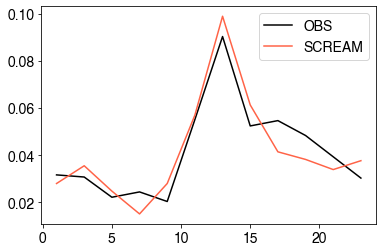

In [26]:
binhour_v = binhour[:-1] + np.diff(binhour)/2.
plt.plot(binhour_v, pdf_inithour_obs_l, color='k', label='OBS')
plt.plot(binhour_v, pdf_inithour_wrf_l, color='tomato', label='SCREAM')
plt.legend()

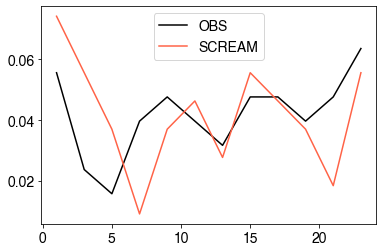

In [27]:
plt.plot(binhour_v, pdf_inithour_obs_o, color='k', label='OBS')
plt.plot(binhour_v, pdf_inithour_wrf_o, color='tomato', label='SCREAM')
plt.legend()

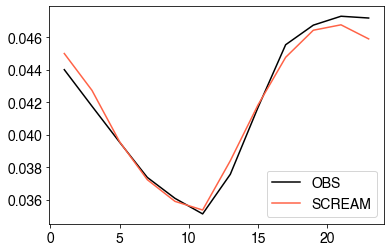

In [28]:
plt.plot(binhour_v, pdf_mcshour_obs_l, color='k', label='OBS')
plt.plot(binhour_v, pdf_mcshour_wrf_l, color='tomato', label='SCREAM')
plt.legend()

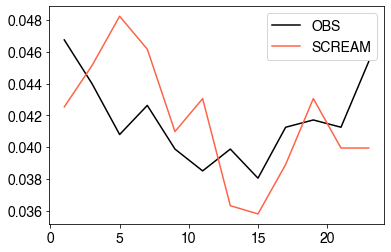

In [29]:
plt.plot(binhour_v, pdf_mcshour_obs_o, color='k', label='OBS')
plt.plot(binhour_v, pdf_mcshour_wrf_o, color='tomato', label='SCREAM')
plt.legend()